In [139]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.decomposition import PCA
sns.set_style("white")

# Parameters of the plots
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [65]:
def importances(model, col_array, title): 
    # Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    print("Top Important Features\n", title)
    #for f in range(col_array.shape[1]-1): 
    for f in range(10): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
        
    #Mean Feature Importance 
    print("\nMean Feature Importance ", np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices], color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=8, rotation=90)
    plt.xlim([-1, 10])
    plt.show()

Nous avons 6068 messages et 251 stations


Text(0.5,1,'Nombre de stations détectant le message')

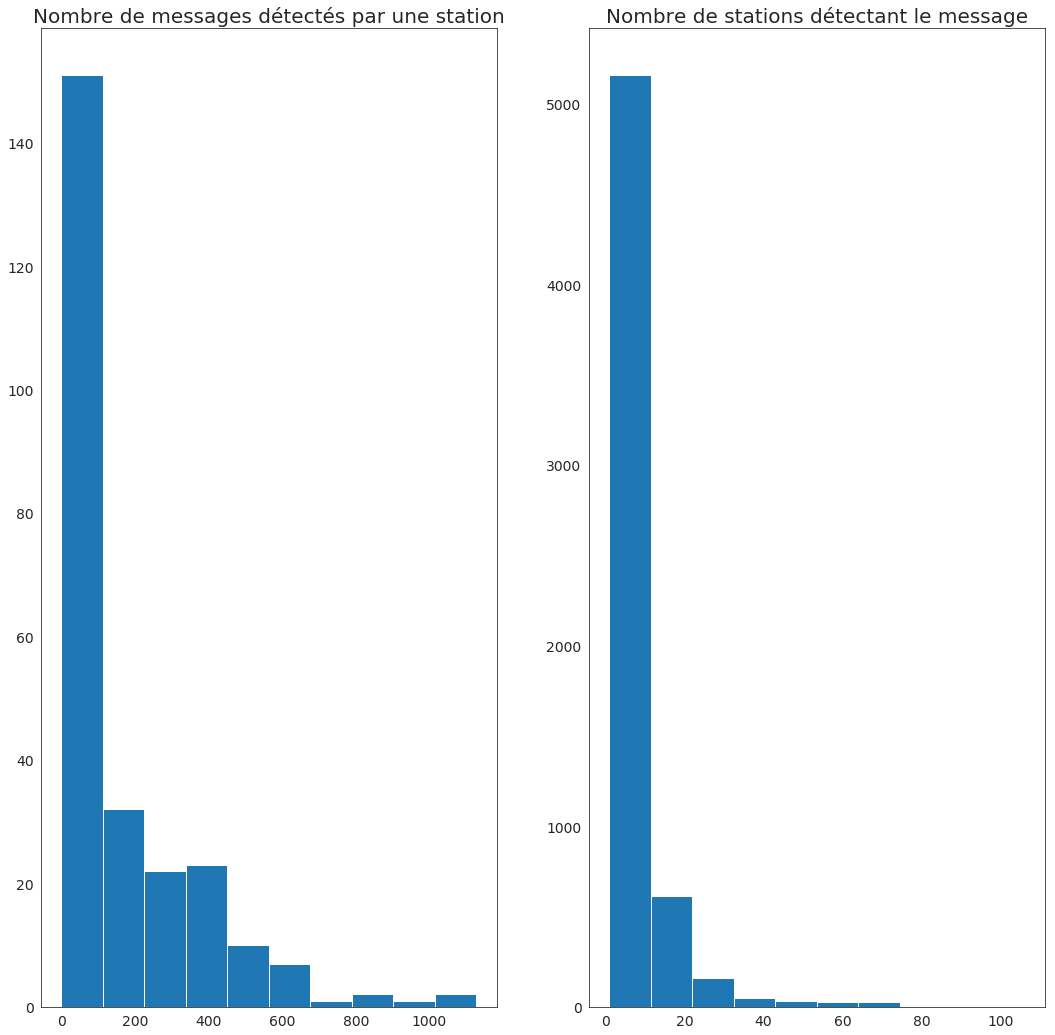

In [66]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
df = pd.read_csv('pos_train_list.csv')

# Unique message
id_m = df_mess_train['messid']
lat = df['lat']
lng = df['lng']
locations_m_= pd.concat([id_m,lat,lng],axis=1)
lm = locations_m_.groupby('messid').mean()
locations_message = list(lm.values)
#Unique station
lat_bs = df_mess_train['bs_lat']
lng_bs = df_mess_train['bs_lng']
locations_bs_ = pd.concat([df_mess_train['bsid'],lat_bs,lng_bs],axis=1).groupby('bsid').mean()
location_bs = list(locations_bs_.values)
print("Nous avons %i messages et %i stations"%((len(locations_message)),len(location_bs)))

bsid_importance = df_mess_train.groupby(['bsid']).count()["messid"]

bsid_localisation = df_mess_train.groupby(['bsid']).mean()[['bs_lat','bs_lng']]

bsid_importance_100 = bsid_importance[bsid_importance>=100]
listbsid_importance_100 = bsid_importance_100.iloc[:].index
bsid_importance_50 = bsid_importance[bsid_importance<100]
listbsid_importance_50 = bsid_importance_50.iloc[:].index
#To remove maybe
bsid_importance_1 = bsid_importance[bsid_importance==1]
bsid_importance_1
listbsid_importance_1 = bsid_importance_1.iloc[:].index

bsid_importance_2 = bsid_importance[bsid_importance==2]
bsid_importance_2
listbsid_importance_2 = bsid_importance_2.iloc[:].index

#Coodinates and bsid
plt.figure(figsize=(18,18))
plt.subplot(121)
station_lessimportant = locations_bs_.loc[listbsid_importance_1]
station_lessimportant2 = locations_bs_.loc[listbsid_importance_2]
station_important_50 = locations_bs_.loc[listbsid_importance_50]
station_important_100 = locations_bs_.loc[listbsid_importance_100]
plt.title("Nombre de messages détectés par une station")
plt.hist(bsid_importance)

plt.subplot(122)
data = df_mess_train.groupby(['messid']).count()["bsid"]
data_with_3_pos_more = data[data>3].count()
data_with_3_pos = data[data==3].count()
data_with_2_pos = data[data==2].count()
data_with_1_pos = data[data==1].count()
mess1 = lm.loc[data[data==1].index]
mess2 = lm.loc[data[data==2].index]
mess3 = lm.loc[data[data==3].index]
mess4 = lm.loc[data[data>3].index]
plt.hist(data)
plt.title('Nombre de stations détectant le message')

#Coordinates and nseq

# Similarité dans les distributions nseq, rssi et bs_lat

(array([ 2.,  0.,  1.,  2.,  7., 52., 38.,  6.,  3.,  2.]),
 array([110.  , 112.45, 114.9 , 117.35, 119.8 , 122.25, 124.7 , 127.15,
        129.6 , 132.05, 134.5 ]),
 <a list of 10 Patch objects>)

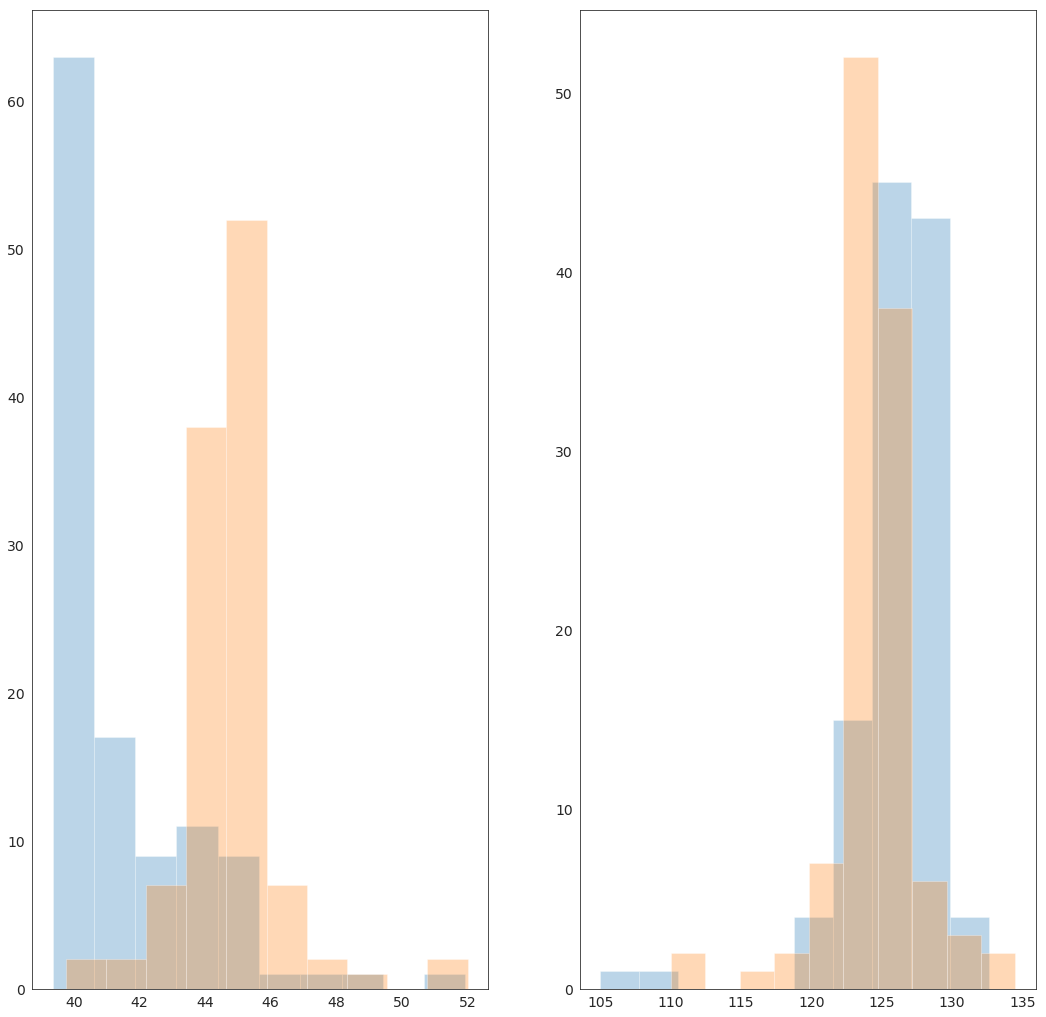

In [67]:
c = df_mess_train.groupby('did').mean()
plt.figure(figsize=(18,18))
plt.subplot(121)
plt.hist(c['bs_lat'],alpha=0.3,label='bs_lat')
plt.hist(-c['nseq']*7+52,alpha=0.3,label='nseq')
plt.subplot(122)
plt.hist(-c['rssi'],alpha=0.3)
plt.hist(c['nseq']*14+110,alpha=0.3)

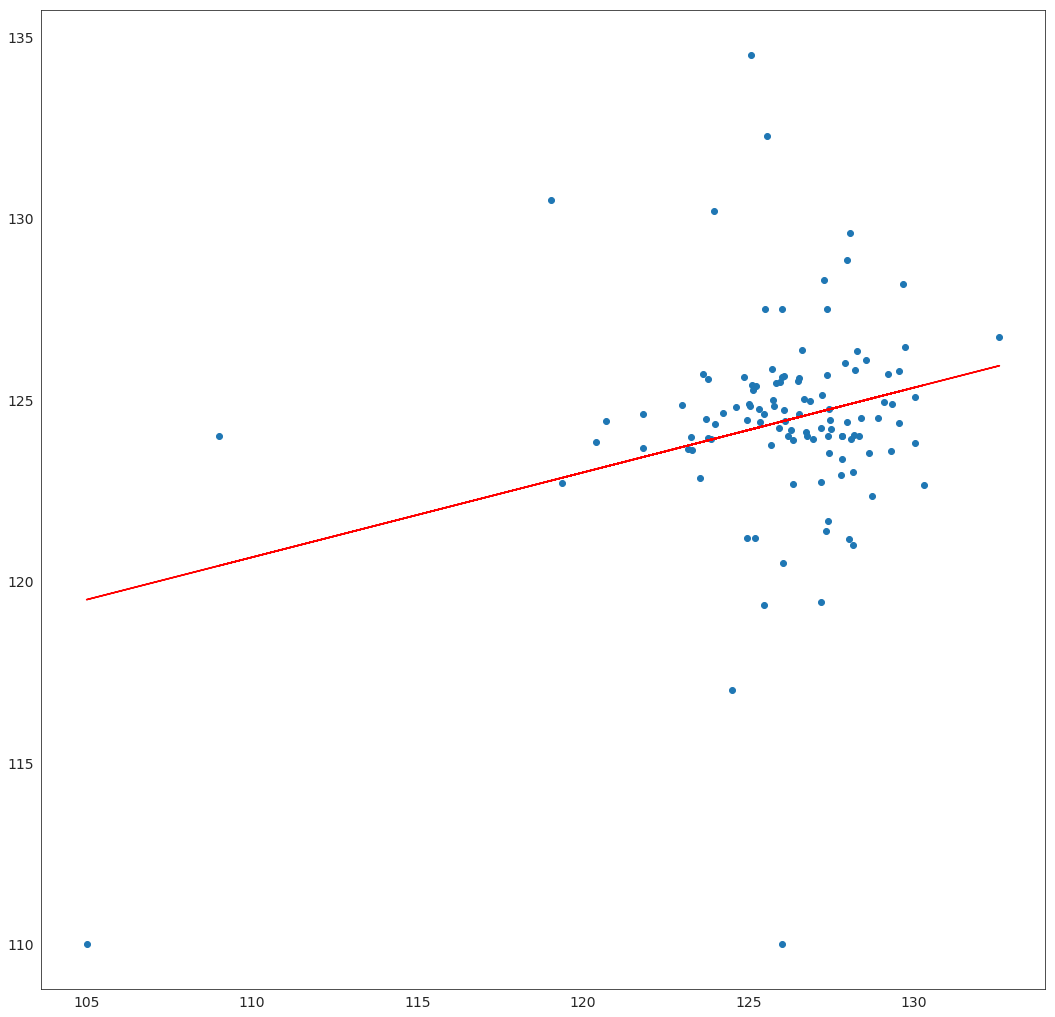

In [68]:
plt.figure(figsize=(18,18))
plt.scatter(-c['rssi'],c['nseq']*14+110)
l = LinearRegression()
xtrain2 = (-c['rssi'].values).reshape(-1,1)
ytrain2 = (c['nseq'].values)*14 +110
l.fit(xtrain2,ytrain2)
ypr = l.predict(xtrain2)
plt.plot(xtrain2,ypr,'r')
#print(r2_score(ytrain,ypr))

# 1. Original spatial distribution of stations and messages 

In [69]:
# Load train and test data
X_train = pd.read_csv('my_train_merged.csv') # train set
X_test = pd.read_csv('my_test_merged.csv') # test set

y_train = X_train.iloc[:, -2:]
X_train = X_train.drop(columns=['lat', 'lng'])

y_test = X_test.iloc[:, -2:]
X_test = X_test.drop(columns=['lat', 'lng'])

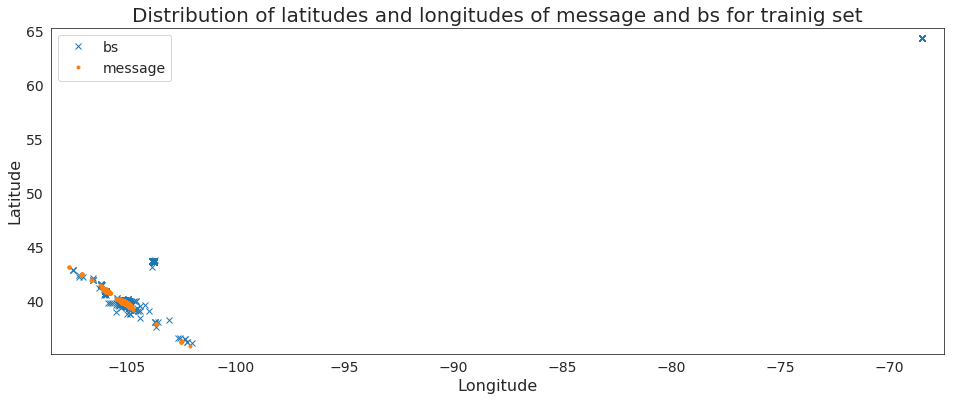

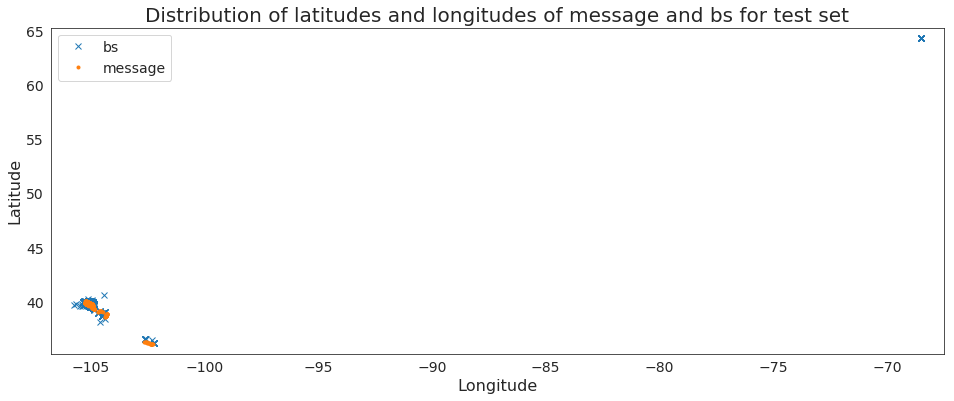

In [70]:
# Plotting latitudes and longitudes of bs and messages for training and test sets
plt.figure(figsize=(16,6))
plt.plot(X_train['bs_lng'], X_train['bs_lat'], 'x', label='bs')
plt.plot(y_train['lng'], y_train['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes of message and bs for trainig set')
plt.legend()

plt.figure(figsize=(16,6))
plt.plot(X_test['bs_lng'], X_test['bs_lat'], 'x', label='bs')
plt.plot(y_test['lng'], y_test['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_test['bs_lng'].min()-1, X_test['bs_lng'].max()+1)
plt.ylim(X_test['bs_lat'].min()-1, X_test['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes of message and bs for test set')
plt.legend()


# 2. Analysis of distance between stations and messages

In [71]:
# Functions to compute distances

# Option 1
def calc_distance_bs_message(X, pos):
    df = X.join(pos)
    
    mess_lat = df['lat'] * np.pi / 180
    bs_lat = df['bs_lat'] * np.pi / 180
    mess_lng = df['lng'] * np.pi / 180
    bs_lng = df['bs_lng'] * np.pi / 180

    dlon = bs_lng - mess_lng
    dlat = bs_lat - mess_lat
    R = 6373
    a = (np.sin(dlat/2))**2 + np.cos(mess_lat) * np.cos(bs_lat) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c    
    
    return distance

# Option 2
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

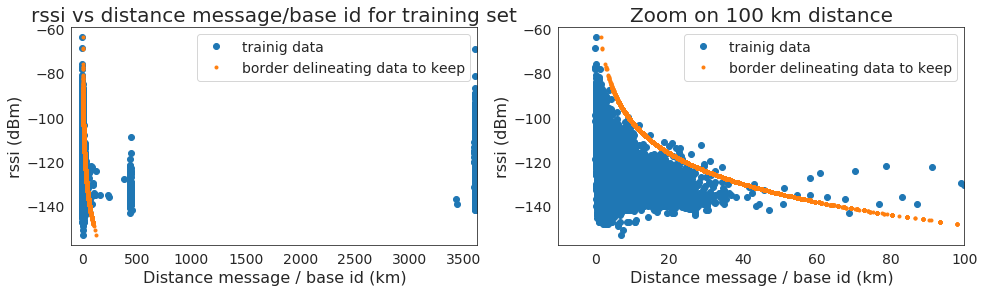

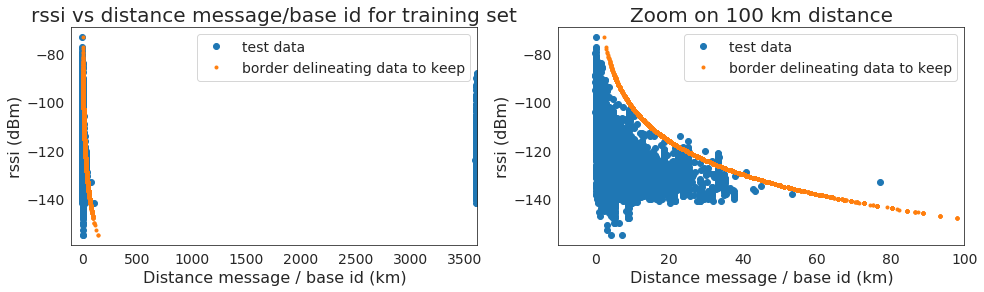

In [72]:
# Defining distances of datasets and distances to keep (option 1)
X_train['distance'] = calc_distance_bs_message(X_train, y_train)
X_test['distance'] = calc_distance_bs_message(X_test, y_test)

## Defining distances of datasets and distances to keep (option 2)
#df = X_train.join(y_train)
#X_train['distance'] = vincenty_vec(df[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
#X_train['distance'] /= 1000
#df = X_test.join(y_test)
#X_test['distance'] = vincenty_vec(df[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
#X_test['distance'] /= 1000

d_keep_train = np.exp(- X_train['rssi'] / 20) * 0.06
d_keep_test = np.exp(- X_test['rssi'] / 20) * 0.06

# Plotting distances and rssi of bs and messages for training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_train['distance'], X_train['rssi'], 'o', label='trainig data')
plt.plot(d_keep_train, X_train['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt.xlim(-100, X_train['distance'].max())
plt. title('rssi vs distance message/base id for training set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train['distance'], X_train['rssi'], 'o', label='trainig data')
plt.plot(d_keep_train, X_train['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

# Plotting distances and rssi of bs and messages for test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test['distance'], X_test['rssi'], 'o', label='test data')
plt.plot(d_keep_test, X_test['rssi'],'.', label='border delineating data to keep')
plt.xlim(-100, X_test['distance'].max())
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test['distance'], X_test['rssi'], 'o', label='test data')
plt.plot(d_keep_test, X_test['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

# 3. Correction of misplaced stations 

In [73]:
# Function to correct bs_lat, bs_lng and distances in dataframes
def correct_lat_lng_misplaced_bs(X, y, d_keep):
    
    # Define dataframes
    df = X.join(y)
    df['mul'] = 0
    df['mul'] = df['mul'].where(df['distance'] > d_keep, 1)

    df_1 = df.copy()
    df_1 = df_1.loc[df_1['mul'] != 0]
    df_2 = df.copy()
    df_2 = df_2.loc[df_2['mul'] == 0]

    X_train = df_1.copy()
    X_test = df_2.copy()
    col = ['rssi', 'time_ux','nseq','lat', 'lng']
    X_train = X_train[col]
    X_test = X_test[col]
    ground_truth_lat = df_1['bs_lat']
    ground_truth_lng = df_1['bs_lng']
    
    # Fit non linear regression
    clr = RandomForestRegressor(n_estimators=100)
    clr.fit(X_train, ground_truth_lat)
    y_pred_lat = clr.predict(X_test)

    clr.fit(X_train, ground_truth_lng)
    y_pred_lng = clr.predict(X_test)
    
    df_2['bs_lat'] = df_2['bs_lat'] * df_2['mul'] + y_pred_lat
    df_2['bs_lng'] = df_2['bs_lng'] * df_2['mul'] + y_pred_lng

    # Prepare final result with computation of distances
    result = pd.concat([df_1, df_2])
    result = result.drop(columns=['mul','distance'])
    result['distance'] = calc_distance_bs_message(result.iloc[:, :-2], result.iloc[:, -2:])
    result['d_keep'] = d_keep
    #result = result.drop(columns=['lat', 'lng'])
    return result.drop(columns=['lat', 'lng']), result[['lat', 'lng']]

In [74]:
# Corrected data
X_train_c, y_train_c = correct_lat_lng_misplaced_bs(X_train, y_train, d_keep_train)
X_test_c, y_test_c = correct_lat_lng_misplaced_bs(X_test, y_test, d_keep_test)

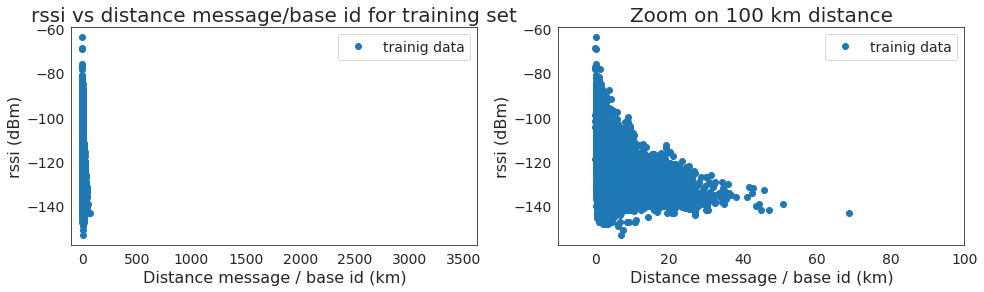

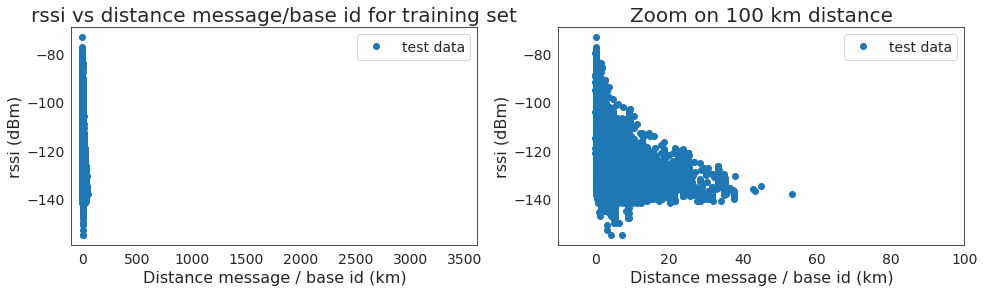

In [75]:
# Plotting distances and rssi of bs and messages for corrected training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_train_c['distance'], X_train_c['rssi'], 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.xlim(-100, X_train['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train_c['distance'], X_train_c['rssi'], 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

# Plotting distances and rssi of bs and messages for corrected test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test_c['distance'], X_test_c['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.xlim(-100, X_test['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_c['distance'], X_test_c['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

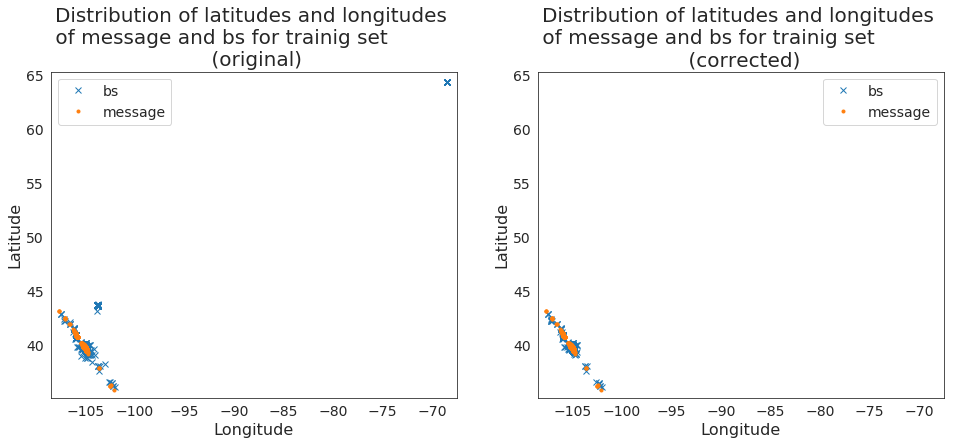

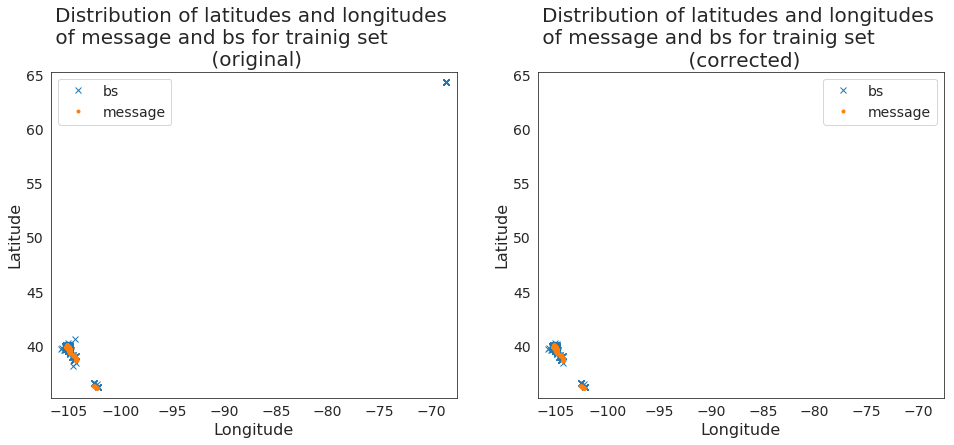

In [76]:
# Plotting latitudes and longitudes of bs and messages for training and test sets
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(X_train['bs_lng'], X_train['bs_lat'], 'x', label='bs')
plt.plot(y_train['lng'], y_train['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (original)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train_c['bs_lng'], X_train_c['bs_lat'], 'x', label='bs')
plt.plot(y_train_c['lng'], y_train_c['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (corrected)')
plt.legend()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(X_test['bs_lng'], X_test['bs_lat'], 'x', label='bs')
plt.plot(y_test['lng'], y_test['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_test['bs_lng'].min()-1, X_test['bs_lng'].max()+1)
plt.ylim(X_test['bs_lat'].min()-1, X_test['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (original)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_c['bs_lng'], X_test_c['bs_lat'], 'x', label='bs')
plt.plot(y_test_c['lng'], y_test_c['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_test['bs_lng'].min()-1, X_test['bs_lng'].max()+1)
plt.ylim(X_test['bs_lat'].min()-1, X_test['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (corrected)')
plt.legend()

# 4. Predictions

## Feature matrix and ground truth

In [77]:
listOfBs = np.union1d(np.unique(X_train_c['bsid']), np.unique(X_test_c['bsid'])) # determine all Base stations that received at least 1 message

In [166]:
df_feat

,879,911,921,944,980,1012,1086,1092,1120,1148,...,timeux_8747,timeux_9784,timeux_9899,timeux_10134,timeux_10148,timeux_10151,timeux_10162,timeux_10999,timeux_11007,timeux_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0


In [ ]:
def categorize(df, cols_name):
    for k in range(df.shape[1]):
        df[cols_name+str(k+1)] = df.loc[:, cols_name+str(k+1)].map({1:k+1, 0:0})
    return df
df_feat.loc[idx, dist_bsid_list] = dist_list.values   

bsid = train.loc[:, 'Wilderness_Area1': 'Wilderness_Area4']
wilderness = categorize(wilderness, 'Wilderness_Area')
wilderness = wilderness.sum(axis=1).astype('category')

train['wilderness']=wilderness 

In [78]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):
    lat_listOfBs = ['lat_' + s for s in list(listOfBs.astype(str))]
    lng_listOfBs = ['lng_' + s for s in list(listOfBs.astype(str))]
    nseq_listOfBs = ['nseq_' + s for s in list(listOfBs.astype(str))]
    timeux_listOfBs = ['timeux_' + s for s in list(listOfBs.astype(str))]
    dist_listOfBs = ['dist_' + s for s in list(listOfBs.astype(str))]
    dkeep_listOfBs = ['dkeep_' + s for s in list(listOfBs.astype(str))]
    feature_cols = list(listOfBs.astype(str)) + lat_listOfBs + lng_listOfBs \
                    + nseq_listOfBs + dist_listOfBs + dkeep_listOfBs + timeux_listOfBs
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(feature_cols))), columns = feature_cols) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:  
        #print(key)
        df_mess_bs_group.get_group(key)
        bsid_list = df_mess_bs_group.get_group(key)['bsid'].astype(str)
        lat_bsid_list = ['lat_' + s for s in list(bsid_list.astype(str))]
        lng_bsid_list = ['lng_' + s for s in list(bsid_list.astype(str))]
        nseq_bsid_list = ['nseq_' + s for s in list(bsid_list.astype(str))]
        dist_bsid_list = ['dist_' + s for s in list(bsid_list.astype(str))]
        dkeep_bsid_list = ['dkeep_' + s for s in list(bsid_list.astype(str))]
        timeux_bsid_list = ['timeux_' + s for s in list(bsid_list.astype(str))]        
        rssi_list = df_mess_bs_group.get_group(key)['rssi']
        bs_lat_list = df_mess_bs_group.get_group(key)['bs_lat']
        bs_lng_list = df_mess_bs_group.get_group(key)['bs_lng']
        nseq_list = df_mess_bs_group.get_group(key)['nseq']
        dist_list = df_mess_bs_group.get_group(key)['distance']
        dkeep_list = df_mess_bs_group.get_group(key)['d_keep']
        timeux_list = df_mess_bs_group.get_group(key)['time_ux']
        df_feat.loc[idx, bsid_list] = rssi_list.values
        df_feat.loc[idx, lat_bsid_list] = bs_lat_list.values
        df_feat.loc[idx, lng_bsid_list] = bs_lng_list.values
        df_feat.loc[idx, nseq_bsid_list] = nseq_list.values
        df_feat.loc[idx, dist_bsid_list] = dist_list.values        
        df_feat.loc[idx, dkeep_bsid_list] = dkeep_list.values        
        df_feat.loc[idx, timeux_bsid_list] = timeux_list.values        
        #df_feat.loc[idx,bsid_list] = listOfBs
        id_list[idx] = key
        idx = idx + 1
    
    #df_feat['count'] = df_count_messid['count']
    return df_feat, id_list # add id value of each message for the correspondance to message

In [79]:
# Generate train features matrix
df_feat, id_list_train = feat_mat_const(X_train_c, listOfBs)
df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,timeux_8747,timeux_9784,timeux_9899,timeux_10134,timeux_10148,timeux_10151,timeux_10162,timeux_10999,timeux_11007,timeux_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
len(listOfBs) * 7 # 7 set of features

1757

In [81]:
# Generate train features matrix
df_feat_test, id_list_test = feat_mat_const(X_test_c, listOfBs)
df_feat_test.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,timeux_8747,timeux_9784,timeux_9899,timeux_10134,timeux_10148,timeux_10151,timeux_10162,timeux_10999,timeux_11007,timeux_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,1.463586e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calcul de la matrice de covariance  

In [116]:
df2 = pd.DataFrame(df_feat)
COV = df2.cov()
COV


,879,911,921,944,980,1012,1086,1092,1120,1148,...,timeux_8747,timeux_9784,timeux_9899,timeux_10134,timeux_10148,timeux_10151,timeux_10162,timeux_10999,timeux_11007,timeux_11951
879,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
911,0.0,3.368945e+00,3.589860e+00,-2.450715e-03,-1.555662e-03,-5.232672e-02,-3.594694e-02,0.0,-8.502480e-04,-8.127371e-04,...,1.472003e+08,9.244453e+06,2.724446e+09,3.678240e+07,9.196853e+06,1.936138e+09,3.291100e+09,9.196853e+06,1.316993e+09,-4.083273e+10
921,0.0,3.589860e+00,3.825260e+00,-2.611417e-03,-1.657673e-03,-5.575798e-02,-3.830412e-02,0.0,-9.060020e-04,-8.660313e-04,...,1.568528e+08,9.850647e+06,2.903098e+09,3.919436e+07,9.799925e+06,2.063098e+09,3.506910e+09,9.799925e+06,1.403354e+09,-4.351029e+10
944,0.0,-2.450715e-03,-2.611417e-03,1.161585e+01,-4.998521e-03,-1.681318e-01,-1.155017e-01,0.0,-2.731944e-03,-2.611417e-03,...,4.729715e+08,2.970349e+07,8.753958e+09,1.181861e+08,2.955054e+07,6.221033e+09,1.057468e+10,2.955054e+07,4.231651e+09,2.970347e+07
980,0.0,-1.555662e-03,-1.657673e-03,-4.998521e-03,7.007851e+00,-1.067265e-01,-7.331802e-02,0.0,-1.734181e-03,-1.657673e-03,...,-4.044248e+10,1.885515e+07,-3.518588e+10,7.502202e+07,-4.072395e+10,-3.679373e+10,-3.403013e+10,-4.072395e+10,-3.805655e+10,1.885514e+07
1012,0.0,-5.232672e-02,-5.575798e-02,-1.681318e-01,-1.067265e-01,2.420217e+02,5.859300e+00,0.0,-5.833143e-02,-5.575798e-02,...,1.009871e+10,6.342175e+08,1.869111e+11,2.523463e+09,6.309518e+08,1.328291e+11,2.257865e+11,6.309518e+08,9.035258e+10,6.342172e+08
1086,0.0,-3.594694e-02,-3.830412e-02,-1.155017e-01,-7.331802e-02,5.859300e+00,1.766210e+02,0.0,-4.007200e-02,-3.830412e-02,...,6.937519e+09,4.356890e+08,-1.105389e+12,-1.306947e+11,4.334456e+08,-8.334080e+11,-9.055496e+11,4.334456e+08,-4.912656e+11,4.356889e+08
1092,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1120,0.0,-8.502480e-04,-9.060020e-04,-2.731944e-03,-1.734181e-03,-5.833143e-02,-4.007200e-02,0.0,4.186510e+00,-9.060020e-04,...,1.640922e+08,1.030529e+07,3.037087e+09,4.100333e+07,1.025223e+07,2.158318e+09,3.668767e+09,1.025223e+07,1.468124e+09,1.030529e+07
1148,0.0,-8.127371e-04,-8.660313e-04,-2.611417e-03,-1.657673e-03,-5.575798e-02,-3.830412e-02,0.0,-9.060020e-04,3.825260e+00,...,1.568528e+08,9.850647e+06,2.903098e+09,3.919436e+07,9.799925e+06,2.063098e+09,3.506910e+09,9.799925e+06,1.403354e+09,9.850642e+06


In [111]:
U, s, V = np.linalg.svd(COV, full_matrices = True)

## Valeurs propres de la matrice de covariance

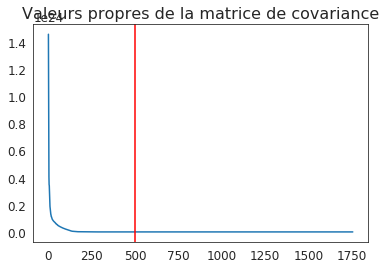

In [160]:
fig = plt.figure()
plt.title("Valeurs propres de la matrice de covariance")
plt.plot(s[:])
#plt.axis([0,500,0,1000])
plt.axvline(500, c='r')

On peut donc appliquer une PCA avec les 200 valeurs les plus grandes. 

In [161]:
df_feat_pca = np.dot(df_feat, U[:, :200])
df_feat_test_pca = np.dot(df_feat_test, U[:, :200])

In [82]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [83]:
gr_truth_lat_train, gr_truth_lng_train = ground_truth_const(X_train_c, y_train_c)

In [84]:
gr_truth_lat_train.shape

(4418,)

In [85]:
len(np.unique(X_train_c['messid']))

4418

In [86]:
gr_truth_lat_test, gr_truth_lng_test = ground_truth_const(X_test_c, y_test_c)
gr_truth_lat_test.shape

(1650,)

In [87]:
len(np.unique(X_test_c['messid']))

1650

## Model and prediction

In [155]:
def regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, df_test, gr_truth_lat_test, gr_truth_lng_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    #reg = linear_model.LinearRegression()
    #reg = RandomForestRegressor(random_state=2792)
    reg = ExtraTreesRegressor()

    reg.fit(X_train, gr_truth_lat_train);
    y_pred_lat = reg.predict(df_test) 
    print("Latitude Accuracy :", reg.score(X_test, gr_truth_lat_test))
    #importances(reg, df_feat, "Latitude Features utilisée")

    reg.fit(X_train, gr_truth_lng_train);
    y_pred_lng = reg.predict(df_test) 
    print("Longitude Accuracy :", reg.score(X_test, gr_truth_lng_test))
    #importances(reg, df_feat, "Longitude Features utilisée")
    
    return y_pred_lat, y_pred_lng

Latitude Accuracy : 0.3016183212824498
Top Important Features
 Latitude Features utilisée
1. 4790 (0.247815)
2. lng_4790 (0.185861)
3. timeux_4790 (0.123909)
4. lat_4790 (0.061952)
5. lng_3613 (0.043968)
6. 3613 (0.029350)
7. lng_2831 (0.013441)
8. lat_7490 (0.013229)
9. dkeep_1828 (0.012168)
10. timeux_1828 (0.012168)

Mean Feature Importance  0.0005691519635742744


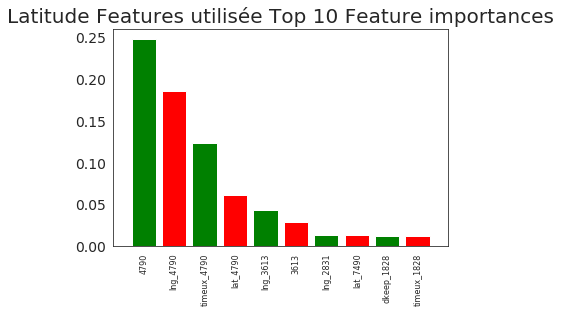

Longitude Accuracy : 0.34766340661847783
Top Important Features
 Longitude Features utilisée
1. timeux_4790 (0.256448)
2. lat_4790 (0.192305)
3. lng_4790 (0.128203)
4. 4790 (0.064253)
5. 1828 (0.039485)
6. timeux_3613 (0.022192)
7. lat_3613 (0.022154)
8. lng_3613 (0.022144)
9. lng_1828 (0.016922)
10. lat_1534 (0.014420)

Mean Feature Importance  0.0005691519635742744


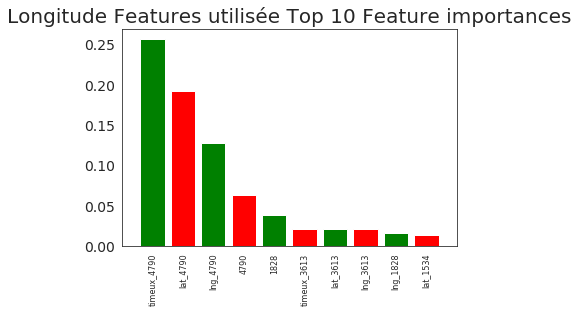

In [89]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
                                               df_feat_test, gr_truth_lat_test, gr_truth_lng_test)

## Prediction on training
#y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
#                                               df_feat, gr_truth_lat_train, gr_truth_lng_train)

In [162]:
y_pred_lat_pca, y_pred_lng_pca = regressor_and_predict(df_feat_pca, gr_truth_lat_train, gr_truth_lng_train, 
                                               df_feat_test_pca, gr_truth_lat_test, gr_truth_lng_test)

Latitude Accuracy : 0.5518212964891509
Longitude Accuracy : 0.6624813765672791


## Error evaluation on test set

In [90]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

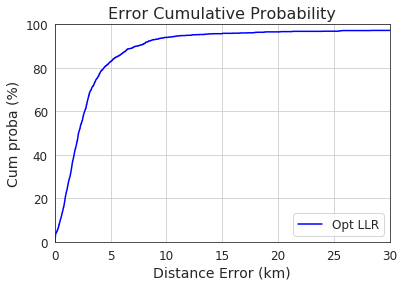

In [163]:
# Plot error distribution
err_vec = Eval_geoloc(gr_truth_lat_test , gr_truth_lng_test, y_pred_lat_pca, y_pred_lng_pca)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [165]:
# Error criterion with PCA
np.percentile(err_vec, 80)

4389.563976816642

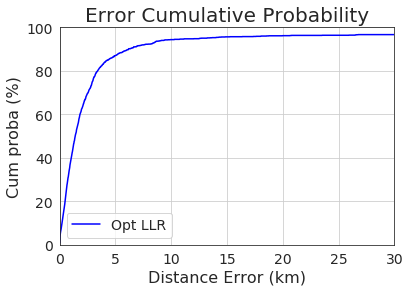

In [91]:
# Plot error distribution
err_vec = Eval_geoloc(gr_truth_lat_test , gr_truth_lng_test, y_pred_lat, y_pred_lng)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [92]:
# Error criterion
np.percentile(err_vec, 80)

3416.866764780051

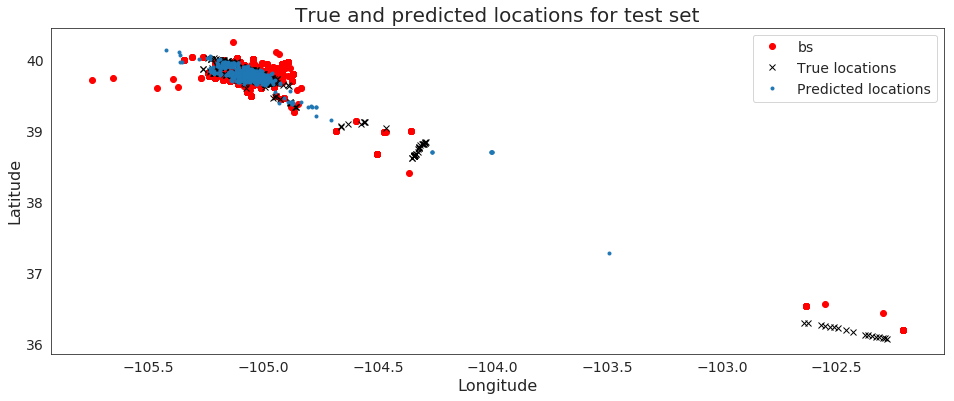

In [93]:
# Plot of true and predicted locations for test set
plt.figure(figsize=(16,6))
plt.plot(X_test_c['bs_lng'], X_test_c['bs_lat'], 'ro', label='bs')
plt.plot(gr_truth_lng_test, gr_truth_lat_test, 'kx', label='True locations')
plt.plot(y_pred_lng, y_pred_lat, '.', label='Predicted locations')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('True and predicted locations for test set')
plt.legend()

## Effect of correcting message positions located south east of Colorado

In [94]:
df_test = pd.DataFrame({'messid': id_list_test,
              'gr_truth_lng': gr_truth_lng_test,
              'y_pred_lng': y_pred_lng,
              'gr_truth_lat': gr_truth_lat_test,
              'y_pred_lat': y_pred_lat,
              'diff_lng': abs(gr_truth_lng_test - y_pred_lng),              
              'diff_lat': abs(gr_truth_lat_test - y_pred_lat)
             })
df_test = df_test.sort_values(by='diff_lng', ascending=False)
df_test.head()

,messid,gr_truth_lng,y_pred_lng,gr_truth_lat,y_pred_lat,diff_lng,diff_lat
1027,57cf759ee541cd01b3b5923f,-102.493982,-105.039371,36.214874,39.780833,2.545389,3.565960
1026,57cf72ff12f1437531e332ec,-102.512060,-105.039371,36.226397,39.780833,2.527312,3.554436
1025,57cf705fcf554f22dcbff061,-102.530501,-105.039371,36.236804,39.780833,2.508870,3.544029
1024,57cf6dc5cf554f22dcbe4c71,-102.548428,-105.039371,36.247396,39.780833,2.490943,3.533437
1023,57cf6b24e541cd01b3ae6cd8,-102.566639,-105.039371,36.258472,39.780833,2.472732,3.522361


In [95]:
# Filtering on df_test when differences higher than 1-5 degrees
df_test[df_test['diff_lat'] > 1.5]

,messid,gr_truth_lng,y_pred_lng,gr_truth_lat,y_pred_lat,diff_lng,diff_lat
1027,57cf759ee541cd01b3b5923f,-102.493982,-105.039371,36.214874,39.780833,2.545389,3.565960
1026,57cf72ff12f1437531e332ec,-102.512060,-105.039371,36.226397,39.780833,2.527312,3.554436
1025,57cf705fcf554f22dcbff061,-102.530501,-105.039371,36.236804,39.780833,2.508870,3.544029
1024,57cf6dc5cf554f22dcbe4c71,-102.548428,-105.039371,36.247396,39.780833,2.490943,3.533437
1023,57cf6b24e541cd01b3ae6cd8,-102.566639,-105.039371,36.258472,39.780833,2.472732,3.522361
1022,57cf634de541cd01b3a96177,-102.623797,-105.039371,36.284692,39.780833,2.415574,3.496141
1021,57cf60bae541cd01b3a7c341,-102.643126,-105.039371,36.288750,39.780833,2.396246,3.492083
1036,57cf977be541cd01b3cc66bd,-102.286895,-104.266114,36.072726,38.710754,1.979219,2.638028
1035,57cf94df12f1437531fa1871,-102.298687,-104.266114,36.079944,38.710754,1.967427,2.630810
1034,57cf9249cf554f22dcd6e486,-102.313746,-104.266114,36.089562,38.710754,1.952368,2.621192


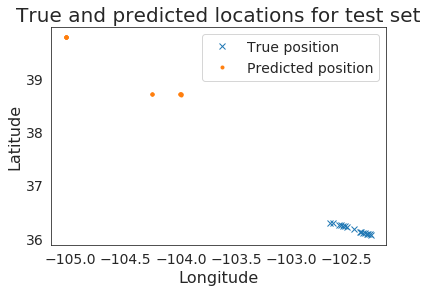

In [96]:
# Messages where differences were higher than 1-5 degrees
plt.plot(df_test[df_test['diff_lat'] > 1.5]['gr_truth_lng'], df_test[df_test['diff_lat'] > 1.5]['gr_truth_lat'],  'x', label='True position')
plt.plot(df_test[df_test['diff_lat'] > 1.5]['y_pred_lng'], df_test[df_test['diff_lat'] > 1.5]['y_pred_lat'], '.', label='Predicted position')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('True and predicted locations for test set')
plt.legend()

In [97]:
# Correlation with original data (isolating stations from Amarillo region in USA)
X_test_c[(X_test_c['bs_lat'] <= 37) & (X_test_c['bs_lng'] >= -103)]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,distance,d_keep
13155,57cf977be541cd01b3cc66bd,1526,476835.0,1.0,-130.333333,1.473223e+12,36.187012,-102.208966,14.512339,40.579213
13156,57cf94df12f1437531fa1871,1526,476835.0,1.0,-127.666667,1.473222e+12,36.187012,-102.208966,14.380193,35.513845
13157,57cf9249cf554f22dcd6e486,1526,476835.0,1.0,-125.000000,1.473221e+12,36.187012,-102.208966,14.355527,31.080769
13158,57cf8fb6cf554f22dcd4fe5d,1526,476835.0,1.0,-128.000000,1.473221e+12,36.187012,-102.208966,14.675770,36.110702
13159,57cf8d1412f1437531f4a714,1526,476835.0,1.5,-134.000000,1.473220e+12,36.187012,-102.208966,15.202673,48.744350
13160,57cf8d1412f1437531f4a714,1148,476835.0,2.0,-138.000000,1.473220e+12,36.555938,-102.548384,53.287496,59.536483
13161,57cf8a7b12f1437531f2f38c,1526,476835.0,1.0,-127.666667,1.473219e+12,36.187012,-102.208966,15.934567,35.513845
13162,57cf87dc12f1437531f13209,1526,476835.0,1.0,-133.333333,1.473219e+12,36.187012,-102.208966,16.482870,47.146320
13163,57cf800812f1437531ebf209,1526,476835.0,0.0,-138.000000,1.473217e+12,36.187012,-102.208966,19.735644,59.536483
13166,57cf9a1c12f1437531fda9c8,1526,476835.0,1.0,-130.666667,1.473223e+12,36.187012,-102.208966,14.996053,41.261201


In [98]:
# Get messids, bs_lat and bs_lng for stations to correct
a_lat = X_test_c[(X_test_c['bs_lat'] <= 37) & (X_test_c['bs_lng'] >= -103)]['bs_lat'].values
a_lng = X_test_c[(X_test_c['bs_lat'] <= 37) & (X_test_c['bs_lng'] >= -103)]['bs_lng'].values
a_mess = X_test_c[(X_test_c['bs_lat'] <= 37) & (X_test_c['bs_lng'] >= -103)]['messid'].values



u, indices = np.unique(a_mess, return_index=True)
a_mess = a_mess[sorted(indices)]
a_lat = a_lat[sorted(indices)]
a_lng = a_lng[sorted(indices)]


In [99]:
# Creating corrected predictions using coordinates form bs stations
df_test['mul'] = 0
df_test['mul'] = df_test['mul'].where(df_test['messid'].isin(a_mess), 1)

df_1 = df_test.copy()
df_1 = df_1.loc[df_1['mul'] != 0]
df_2 = df_test.copy()
df_2 = df_2.loc[df_2['mul'] == 0]

df_2['yc_pred_lat'] = df_2['y_pred_lat'] * df_2['mul'] + a_lat
df_2['yc_pred_lng'] = df_2['y_pred_lng'] * df_2['mul'] + a_lng

df_1['yc_pred_lat'] = df_1['y_pred_lat'] * df_1['mul']
df_1['yc_pred_lng'] = df_1['y_pred_lng'] * df_1['mul']
df_test_c = pd.concat([df_1, df_2]) 

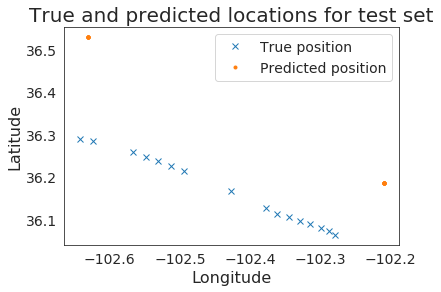

In [100]:
# Corrected messages where differences were higher than 1-5 degrees
plt.plot(df_test_c[df_test_c['diff_lat'] > 1.5]['gr_truth_lng'], df_test_c[df_test_c['diff_lat'] > 1.5]['gr_truth_lat'],  'x', label='True position')
plt.plot(df_test_c[df_test_c['diff_lat'] > 1.5]['yc_pred_lng'], df_test_c[df_test_c['diff_lat'] > 1.5]['yc_pred_lat'], '.', label='Predicted position')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('True and predicted locations for test set')
plt.legend()

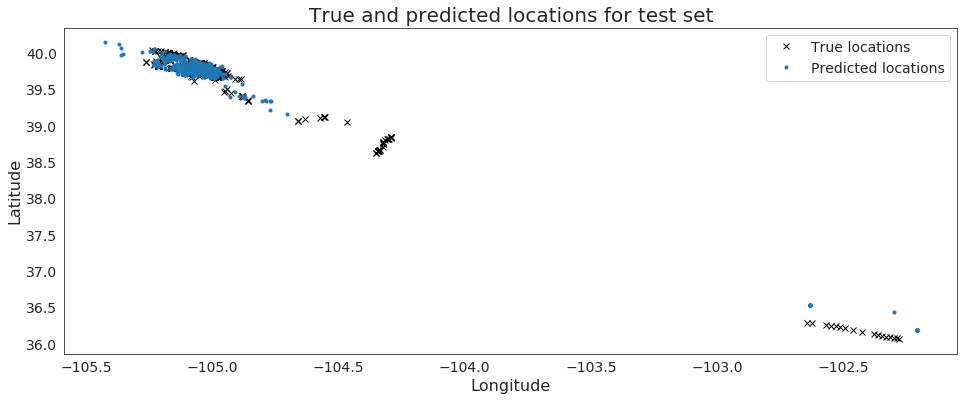

In [101]:
# Plot of true and predicted locations for test set (with corrections)
plt.figure(figsize=(16,6))
plt.plot(df_test_c['gr_truth_lng'], df_test_c['gr_truth_lat'], 'kx', label='True locations')
plt.plot(df_test_c['yc_pred_lng'], df_test_c['yc_pred_lat'], '.', label='Predicted locations')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('True and predicted locations for test set')
plt.legend()

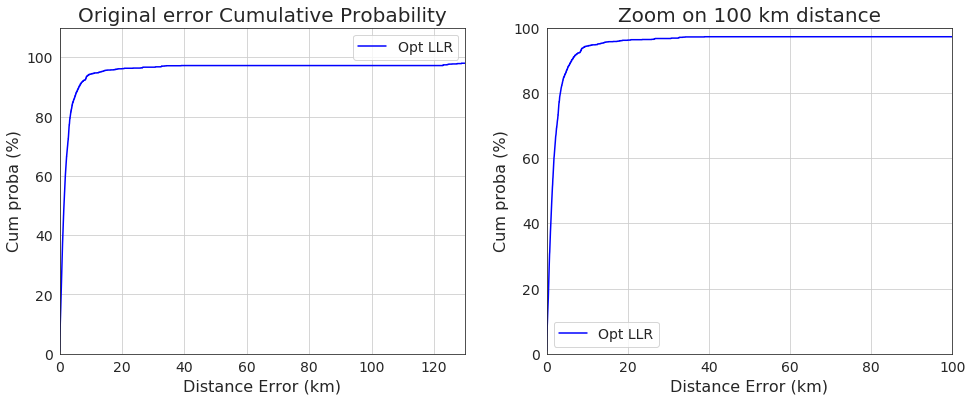

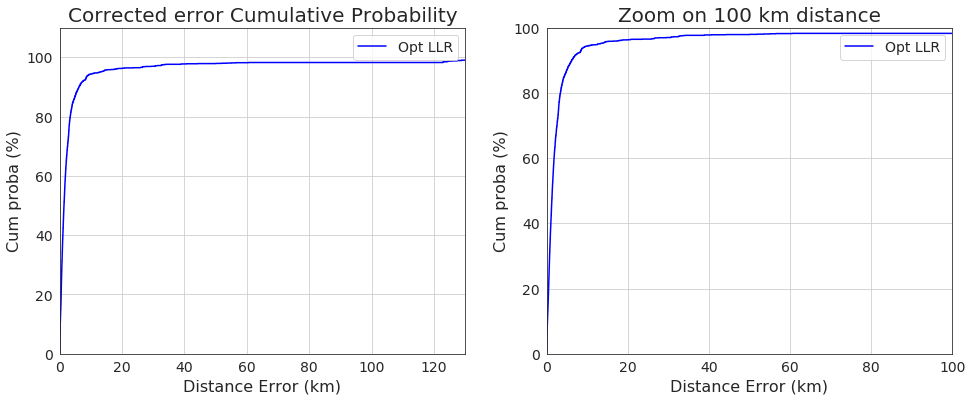

In [102]:
err_vec = Eval_geoloc(df_test_c['gr_truth_lat'].values , df_test_c['gr_truth_lng'].values, df_test_c['y_pred_lat'].values, df_test_c['y_pred_lng'].values)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 130, 0, 110]); 
plt.title('Original error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

plt.subplot(1,2,2)
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 100, 0, 100]); 
plt.title('Zoom on 100 km distance'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

err_vec_c = Eval_geoloc(df_test_c['gr_truth_lat'].values , df_test_c['gr_truth_lng'].values, df_test_c['yc_pred_lat'].values, df_test_c['yc_pred_lng'].values)
values_c, base_c = np.histogram(err_vec_c, bins=50000)
cumulative = np.cumsum(values_c) 
plt.figure(figsize=(16,6));
plt.subplot(1,2,1)
plt.plot(base_c[:-1]/1000, cumulative / np.float(np.sum(values_c))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 130, 0, 110]); 
plt.title('Corrected error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
np.percentile(err_vec_c, 80)
                                                 
plt.subplot(1,2,2)
plt.plot(base_c[:-1]/1000, cumulative / np.float(np.sum(values_c))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 100, 0, 100]); 
plt.title('Zoom on 100 km distance'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [103]:
print(f"Error @ 80 % for original data: {np.percentile(err_vec, 80)} m")
print(f"Error @ 80 % for corrected data coming from South East Colorado: {np.percentile(err_vec_c, 80)} m")

Error @ 80 % for original data: 3416.866764780051 m
Error @ 80 % for corrected data coming from South East Colorado: 3416.866764780051 m


## Computing predictions by avergaing bs stations locations

In [104]:
b_lat = X_test_c.groupby(['messid'])['bs_lat'].mean().values
b_lng = X_test_c.groupby(['messid'])['bs_lng'].mean().values
b_mess = X_test_c.groupby(['messid']).mean().index

In [105]:
df_test2 = pd.DataFrame({'messid': b_mess,
              'yc2_pred_lng': b_lng,             
              'yc2_pred_lat': b_lat,             
             })
df_test2.head()


,messid,yc2_pred_lng,yc2_pred_lat
0,573c8ea8864fce1a9a5fbf7a,-105.033121,39.778865
1,573c9148864fce1a9a616174,-105.047352,39.724504
2,573c939cf0fe6e735ac36de1,-105.060654,39.740524
3,573c9892f0fe6e735ac6603f,-105.075911,39.759395
4,573c9d7b3e952e1912d9f567,-105.074287,39.759461


In [106]:
df_test_c2 = df_test_c.merge(df_test2, on='messid')
df_test_c2.head()

,messid,gr_truth_lng,y_pred_lng,gr_truth_lat,y_pred_lat,diff_lng,diff_lat,mul,yc_pred_lat,yc_pred_lng,yc2_pred_lng,yc2_pred_lat
0,576b81a5cf554f6d991dc3fe,-104.292530,-105.039371,38.839125,39.780833,0.746841,0.941708,1,39.780833,-105.039371,-104.355288,39.000383
1,5847bd31e541cd0e13a086f8,-104.292862,-105.039371,38.839115,39.780833,0.746509,0.941718,1,39.780833,-105.039371,-104.355288,39.000383
2,57754772cf554f3ea39d1745,-104.293496,-105.039371,38.837155,39.780833,0.745875,0.943678,1,39.780833,-105.039371,-104.355288,39.000383
3,58332792cf554f7e3a609f56,-104.293640,-105.039371,38.836891,39.780833,0.745731,0.943942,1,39.780833,-105.039371,-104.355288,39.000383
4,57a21893cf554f465ad82cf8,-104.301277,-105.039371,38.821725,39.780833,0.738094,0.959108,1,39.780833,-105.039371,-104.472822,38.990806


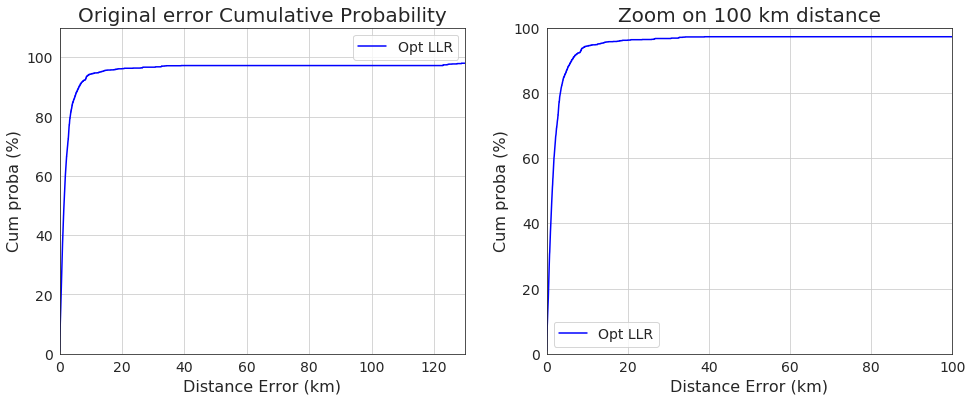

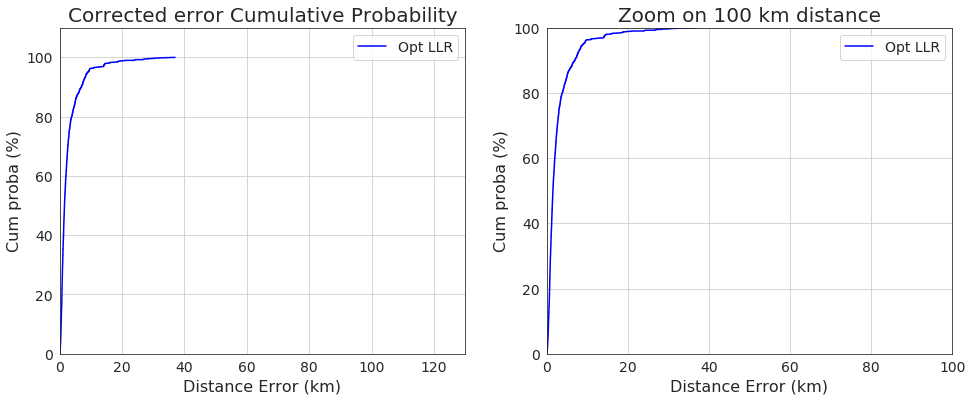

In [107]:
err_vec = Eval_geoloc(df_test_c['gr_truth_lat'].values , df_test_c['gr_truth_lng'].values, df_test_c['y_pred_lat'].values, df_test_c['y_pred_lng'].values)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 130, 0, 110]); 
plt.title('Original error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

plt.subplot(1,2,2)
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 100, 0, 100]); 
plt.title('Zoom on 100 km distance'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

err_vec_c2 = Eval_geoloc(df_test_c2['gr_truth_lat'].values , df_test_c2['gr_truth_lng'].values, df_test_c2['yc2_pred_lat'].values, df_test_c2['yc2_pred_lng'].values)
values_c2, base_c2 = np.histogram(err_vec_c2, bins=50000)
cumulative = np.cumsum(values_c2) 
plt.figure(figsize=(16,6));
plt.subplot(1,2,1)
plt.plot(base_c2[:-1]/1000, cumulative / np.float(np.sum(values_c2))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 130, 0, 110]); 
plt.title('Corrected error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
np.percentile(err_vec_c, 80)
                                                 
plt.subplot(1,2,2)
plt.plot(base_c2[:-1]/1000, cumulative / np.float(np.sum(values_c2))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 100, 0, 100]); 
plt.title('Zoom on 100 km distance'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [108]:
print(f"Error @ 80 % for original data: {np.percentile(err_vec, 80)} m")
print(f"Error @ 80 % for corrected data coming from South East Colorado: {np.percentile(err_vec_c, 80)} m")
print(f"Error @ 80 % for averaging over bs stations: {np.percentile(err_vec_c2, 80)} m")

Error @ 80 % for original data: 3416.866764780051 m
Error @ 80 % for corrected data coming from South East Colorado: 3416.866764780051 m
Error @ 80 % for averaging over bs stations: 3869.5124650942876 m
